In [9]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib as plt

In [ ]:
#df1 = pd.read_excel("/Users/sidichen/Desktop/code/stockdatacollection.xlsx", sheet_name = "JPMorgan")
data = yf.download("JPM", start="2023-08-01", end="2024-12-31")  # Use the correct ticker symbol for JPMorgan
df1 = pd.DataFrame(data)

if isinstance(df1.columns, pd.MultiIndex):
	df1.columns = ['_'.join(col).strip() for col in df1.columns.values]

print(df1.dtypes)

# Ensure the "Close" and "Volume" columns exist and are numeric
df1["Close"] = pd.to_numeric(df1.get("Close", df1.get("Close_JPM", None)), errors="coerce")
df1["Volume"] = pd.to_numeric(df1.get("Volume", df1.get("Volume_JPM", None)), errors="coerce")


# Calculate additional columns
df1["Return"] = df1["Close"].pct_change()
df1["Volatility_20d"] = df1["Return"].rolling(window=20).std()
df1["MA20"] = df1["Close"].rolling(20).mean()
df1["MA60"] = df1["Close"].rolling(60).mean()
df1["MA_Diff"] = df1["MA20"]-df1["MA60"]
df1["Vol_MA20"] = df1["Volume"].rolling(20).mean()
df1["CumReturn"] = (1 + df1["Return"]).cumprod() - 1
df1["Vol_Factor"] = df1["Volume"] / df1["Vol_MA20"]
cum = (1 + df1["Return"]).cumprod()
df1["Drawdown"] = cum / cum.cummax() - 1
max_dd = df1["Drawdown"].min()

print(df1[["Close", "Return", "Volatility_20d"]].head(25))
df1 = df1.loc["2024-01-01":"2024-12-31"]
# Save the DataFrame to an Excel file
df1.to_excel("JPmorgandata.xlsx")

/var/folders/2p/x78cn9790v7dbzdj8g66y7r80000gn/T/ipykernel_51439/3939141938.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("JPM", start="2023-08-01", end="2024-12-31")  # Use the correct ticker symbol for JPMorgan
[*********************100%***********************]  1 of 1 completed

Close_JPM     float64
High_JPM      float64
Low_JPM       float64
Open_JPM      float64
Volume_JPM      int64
dtype: object
                 Close    Return  Volatility_20d
Date                                            
2023-08-01  149.956177       NaN             NaN
2023-08-02  148.257996 -0.011325             NaN
2023-08-03  149.164337  0.006113             NaN
2023-08-04  148.849487 -0.002111             NaN
2023-08-07  149.555481  0.004743             NaN
2023-08-08  148.715942 -0.005614             NaN
2023-08-09  146.722000 -0.013408             NaN
2023-08-10  146.502548 -0.001496             NaN
2023-08-11  147.351654  0.005796             NaN
2023-08-14  147.656952  0.002072             NaN
2023-08-15  143.898026 -0.025457             NaN
2023-08-16  143.287430 -0.004243             NaN
2023-08-17  141.799133 -0.010387             NaN
2023-08-18  142.123520  0.002288             NaN
2023-08-21  142.610092  0.003424             NaN
2023-08-22  139.652542 -0.020739           

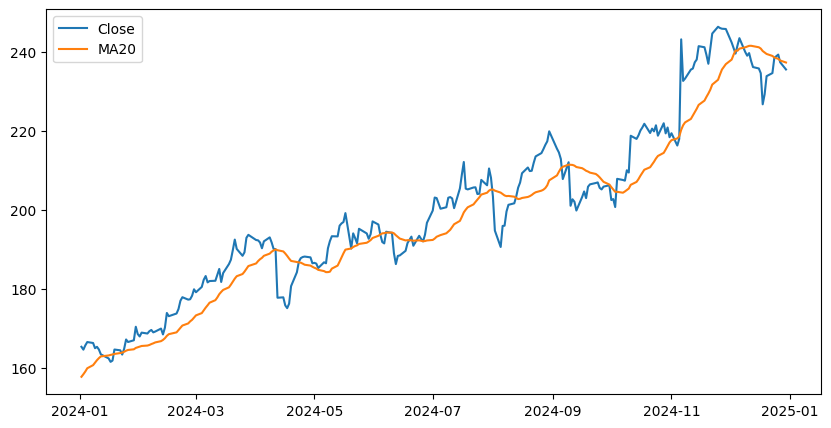

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df1.index, df1["Close"], label="Close")
plt.plot(df1.index, df1["MA20"], label="MA20")
plt.legend()
plt.show()


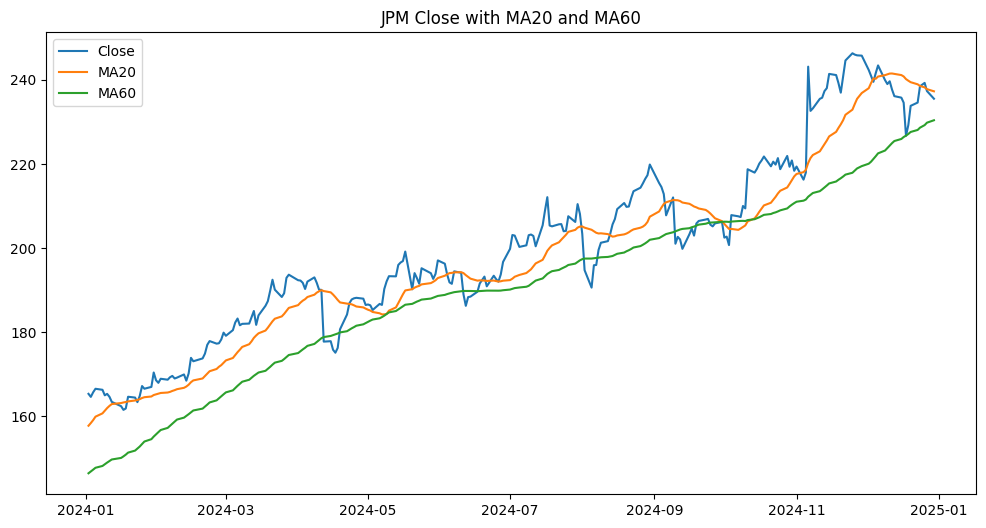

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df1.index, df1["Close"], label="Close")
plt.plot(df1.index, df1["MA20"], label="MA20")
plt.plot(df1.index, df1["MA60"], label="MA60")
plt.legend()
plt.title("JPM Close with MA20 and MA60")
plt.show()


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

features = ["Return","Volatility_20d","MA_Diff","Vol_Factor","CumReturn","Drawdown","Volume"]
X = df1[features].dropna()
y = df1["Return"].shift(-1).dropna()

# 对齐索引
X, y = X.loc[y.index], y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

features = ["Return", "Volatility_20d", "MA_Diff", "Vol_Factor", "CumReturn", "Drawdown"]
X = df1[features].dropna()
y = df1["Return"].shift(-1).dropna()  # 预测下一日收益率

# 对齐索引
X, y = X.loc[y.index], y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

print("模型系数：", model.coef_)
print("测试集得分：", model.score(X_test, y_test))


模型系数： [-0.11712092  0.22484787 -0.00044608 -0.00450509 -0.01599794 -0.03250134]
测试集得分： -0.2703956181180267


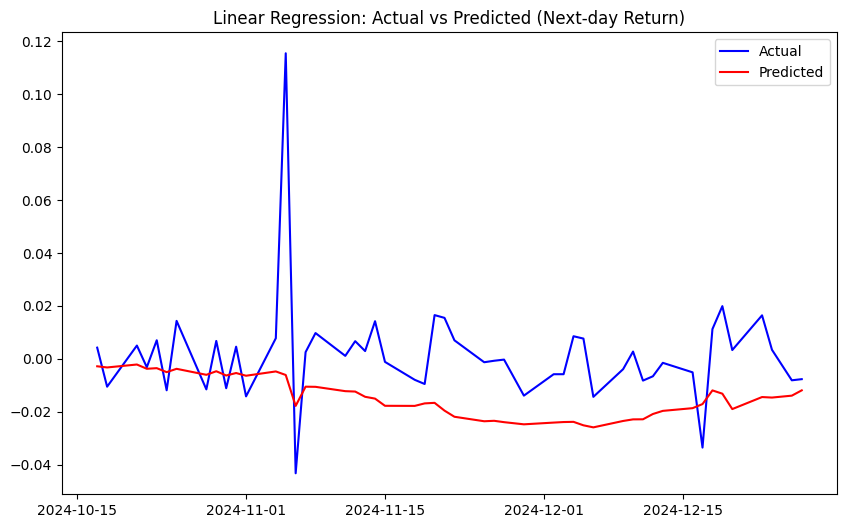

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.title("Linear Regression: Actual vs Predicted (Next-day Return)")
plt.show()
